## Project Summary

This project explores the dynamical evolution of a stellar disk embedded in a static dark matter halo. The disk is modeled using the Miyamoto-Nagai density profile, while the halo follows a Hernquist potential. The goal is to study the system in both equilibrium and perturbed conditions, with particular focus on the formation of a galactic bar.

The study is divided into two main phases:

1. **Equilibrium Modeling**
We numerically generate an initial stable configuration of 30,000 particles using a probability distribution derived from the Miyamoto-Nagai density profile. The initial conditions include both the spatial coordinates and the velocity components, computed from theoretical models using the epicyclic approximation. We then verify dynamical stability through an analysis of radial, vertical, and azimuthal velocity dispersions, Toomre's Q parameter, and the virial theorem.

2. **Bar Formation**
Once equilibrium is confirmed, we introduce controlled perturbations (e.g., by altering halo mass and scale radius) to study the bar instability mechanism. We investigate the onset and evolution of the bar through orbital frequencies and the variation of $\Omega - \kappa/2$ with radius, identifying the potential location of Lindblad resonances.

---

## Repository Contents

This repository contains Jupyter notebooks organized by functionality:

Equilibrium_System.ipynb – Builds the initial particle distribution and computes the velocity field in equilibrium. Also saves the data in a format suitable for treecode simulations.

Equilibrium_Visual.ipynb – Provides 2D/3D visualization, radial and vertical profiles, density maps, and plots of Toomre’s Q and velocity dispersion ratios.

Bar_System.ipynb – Simulate bar formation.

Bar_Visual.ipynb – Visual analysis of bar formation using frequency curves and time evolution (to be completed with output data from treecode).

---

## Simulation Framework

The N-body simulation is performed using a custom version of the Barnes & Hut treecode, modified to include a static Hernquist halo. We export particle data (positions, masses, velocities) to a .txt file compatible with the code's I/O format.
The treecode is executed from a Linux environment (via WSL on Windows), using the following input parameters:

dtime: Integration timestep

eps: Softening length

theta: Opening angle for tree traversal

tstop: Total simulation time

dtout: Time interval between output snapshots

For detailed usage and parameter explanation, see the original Treecode User Guide. [Treecode Documentation](https://legacy.ifa.hawaii.edu/faculty/barnes/treecode/treeguide.html). 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import corner
import emcee
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

### Estimating the Galaxy's Stellar Mass from Its Halo Mass

In this simulation, we're adopting internal units by setting the gravitational constant \( G = 1 \). 
Masses are expressed in solar masses, and distances are in kiloparsecs (kpc). 
This choice simplifies the equations of motion and helps maintain numerical stability during integration.

To estimate the stellar mass of a galaxy from its dark matter halo mass, we rely on the empirical relation introduced by Moster et al. (2013):

$$
\frac{M_{\text{star}}}{M_{\text{halo}}} = 2N \left[ \left( \frac{M_{\text{halo}}}{M_1} \right)^{-\beta} + \left( \frac{M_{\text{halo}}}{M_1} \right)^{\gamma} \right]^{-1}
$$

Here, $N$, $M_1$, $\beta$ and $\gamma$ are parameters calibrated from observations and simulations.  
They vary with redshift ($z$), and we define them below through simple functions, following the trends provided in the literature.

**Reference**:  
Moster, B. P., Naab, T., & White, S. D. M. (2013). *Galactic star formation and stellar mass assembly in the Millennium Simulation*.  
**Monthly Notices of the Royal Astronomical Society**, 428(4), 3121–3138.

In [3]:
# Cosmological scaling relations (Calculate stellar fraction and halo mass)
def M_1(z):
    M_10 = 11.590
    M_11 = 1.195
    return 10**(M_10 + M_11*z/(z+1))

def N_(z):
    N_10 = 0.0351
    N_11 = -0.0247
    return N_10 + N_11*z/(z+1)

def gamma(z):
    gamma_10 = 0.608
    gamma_11 = 0.329
    return gamma_10 + gamma_11*z/(z+1)

def beta(z):
    beta_10 = 1.376
    beta_11 = -0.826
    return beta_10 + beta_11*z/(z+1)

def m_star_m_halo(M, z=0):
    a = (M/M_1(z))**(-beta(z))
    b = (M/M_1(z))**(gamma(z))
    return 2*M*N_(z)/(a + b)

In [4]:
# Simulation setup
num_particles = 30000
M_H_sun = 1e12 
M_D_sun = m_star_m_halo(M_H_sun)

#Rescale the masses in internal units
M_H_1 = 1000
M_D_1 = M_H_1*M_D_sun/M_H_sun
m_particles = float(M_D_1/num_particles)
M_H = M_H_1
M_D = M_D_1

# Miyamoto-Nagai Disk model parameters
a = 3
b = 0.1*a
R_max = 30 # (kpc)
z_max = 5
a_H = 10
const = 1.0

In [5]:
# Volume density (Miyamoto-Nagai)
def rho_D(R, z):
    sqrt_zb = np.sqrt(z**2 + b**2)
    num = b**2*M_D*(a*R**2 + (a + 3*sqrt_zb)*(a + sqrt_zb)**2)
    den = 4*np.pi*(R**2 + (a + sqrt_zb)**2)**(5/2)*(z**2 + b**2)**(3/2)
    return num / den

In [6]:
# Output path
Coord_file = "coordinates_equilibrium.npy"

In [7]:
# Generate if the file does not exist
if os.path.exists(Coord_file):
    print("File", Coord_file, "already exists")   
else:
    def rho_D(R, z, a=a, b=b):
        sqrt_zb = np.sqrt(z**2 + b**2)
        num = b**2*M_D*(a*R**2 + (a + 3*sqrt_zb)*(a + sqrt_zb)**2)
        den = 4*np.pi*(R**2 + (a + sqrt_zb)**2)**(5/2)*(z**2 + b**2)**(3/2)
        return num / den

    def log_prior(params):
        # Flat prior: parameters must lie within defined physical boundaries
        R, z, phi = params
        if (0 <= R <= R_max) and (-z_max <= z <= z_max) and (0 <= phi <= 2*np.pi):
            return 0.0
        return -np.inf  # Reject if outside allowed region

    def log_likelihood(params):
        # Log-likelihood proportional to the Miyamoto-Nagai density
        R, z, phi = params
        return np.log(rho_D(R, z)*2*np.pi*R)

    def log_posterior(params):
        # Combine prior and likelihood for posterior probability
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)

    # MCMC configuration
    ndim = 3  # Number of parameters: R, z, phi
    nwalkers = 30  # Number of parallel walkers
    nsteps = 80000  # Total number of steps in the chain

    # Initial positions randomly sampled from the prior bounds
    initial_guess = np.random.uniform(
        low=[0, -z_max, 0],
        high=[R_max, z_max, 2*np.pi],
        size=(nwalkers, ndim)
    )

    # Run the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
    sampler.run_mcmc(initial_guess, nsteps, progress=True)

    # Estimate autocorrelation time and flatten the chains
    tau = sampler.get_autocorr_time()
    flat_samples = sampler.get_chain(discard=3000, flat=True, thin=int(np.max(tau)))

    unique_samples = np.unique(flat_samples, axis=0)
    if unique_samples.shape[0] < 30000:
        raise ValueError("Not enough unique samples to select 30,000 particles.")
        
    flat_samples_subset = unique_samples[np.random.choice(unique_samples.shape[0], 30000, replace=False)]

    # Convert cylindrical to Cartesian coordinates
    R_samples = flat_samples_subset[:, 0]
    z_samples = flat_samples_subset[:, 1]
    phi_samples = flat_samples_subset[:, 2]

    x_particles = R_samples*np.cos(phi_samples)
    y_particles = R_samples*np.sin(phi_samples)
    z_particles = z_samples

    # Plot sampled distributions
    plt.figure(figsize=(18, 6))

    # Plot of radial distribution
    plt.subplot(131)
    R = np.sqrt(x_particles**2 + y_particles**2)
    plt.hist(R, bins='fd', density=True, color='mediumslateblue', alpha=0.8)
    plt.title('Radial Distribution')
    plt.xlabel('Radius [kpc]')
    plt.ylabel('Density')

    # Plot of vertical (z) distribution
    plt.subplot(132)
    plt.hist(z_particles, bins='fd', density=True, color='mediumseagreen', alpha=0.8)
    plt.title('Z Distribution')
    plt.xlabel('Z [kpc]')
    plt.ylabel('Density')

    # Corner plot showing correlations between parameters
    plt.subplot(133)
    corner.corner(flat_samples, labels=['R', 'z', 'φ'], color='darkorange')
    plt.tight_layout()
    plt.show()  

    coordinates = np.array([x_particles, y_particles, z_particles, R_samples, phi_samples])
    np.save(Coord_file, coordinates)
    print("File saved as", Coord_file)

File coordinates_equilibrium.npy already exists


In [8]:
#Loading file .npy
loaded_coordinates = np.load(Coord_file)
x_particles, y_particles, z_particles, R_particles, phi_particles = loaded_coordinates

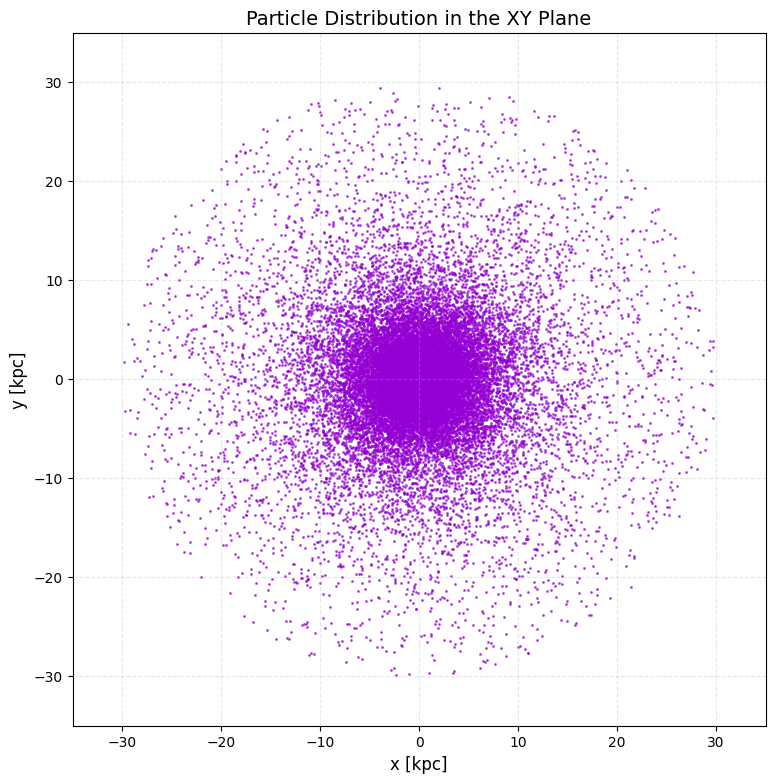

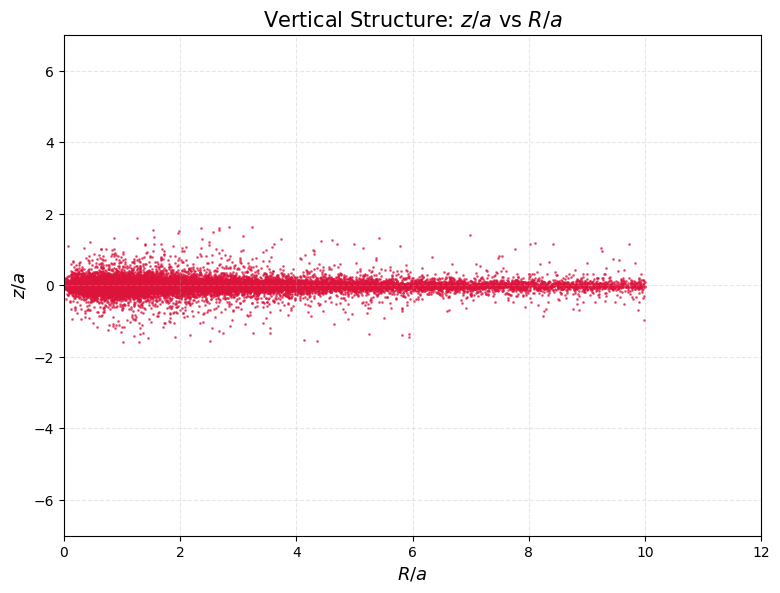

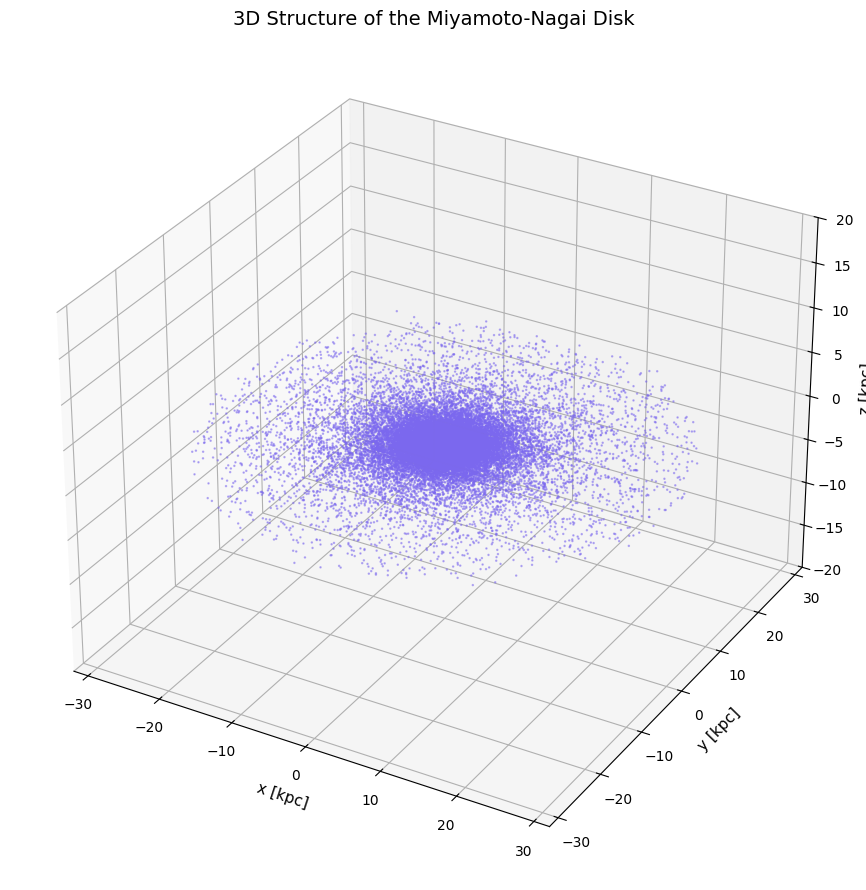

In [9]:
# XY plane distribution of particles
plt.figure(figsize=(9, 9))
plt.scatter(x_particles, y_particles, s=1.2, color='darkviolet', alpha=0.6)
plt.title("Particle Distribution in the XY Plane", fontsize=14)
plt.xlabel("x [kpc]", fontsize=12)
plt.ylabel("y [kpc]", fontsize=12)
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlim(-35, 35)
plt.ylim(-35, 35)
plt.show()

# Plot of z/a vs R/a
plt.figure(figsize=(9, 6.5))
plt.scatter(np.array(R_particles) / a, np.array(z_particles) / a, s=1, color='crimson', alpha=0.6)
plt.xlabel('$R/a$', fontsize=13)
plt.ylabel('$z/a$', fontsize=13)
plt.title('Vertical Structure: $z/a$ vs $R/a$', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(-7, 7)
plt.xlim(0, 12)
plt.show()

# 3D particle distribution
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_particles, y_particles, z_particles, s=0.6, color='mediumslateblue', alpha=0.5)

ax.set_title("3D Structure of the Miyamoto-Nagai Disk", fontsize=14)
ax.set_xlabel("x [kpc]", fontsize=11)
ax.set_ylabel("y [kpc]", fontsize=11)
ax.set_zlabel("z [kpc]", fontsize=11)
ax.set_xlim(-32, 32)
ax.set_ylim(-32, 32)
ax.set_zlim(-20, 20)

plt.tight_layout()
plt.show()

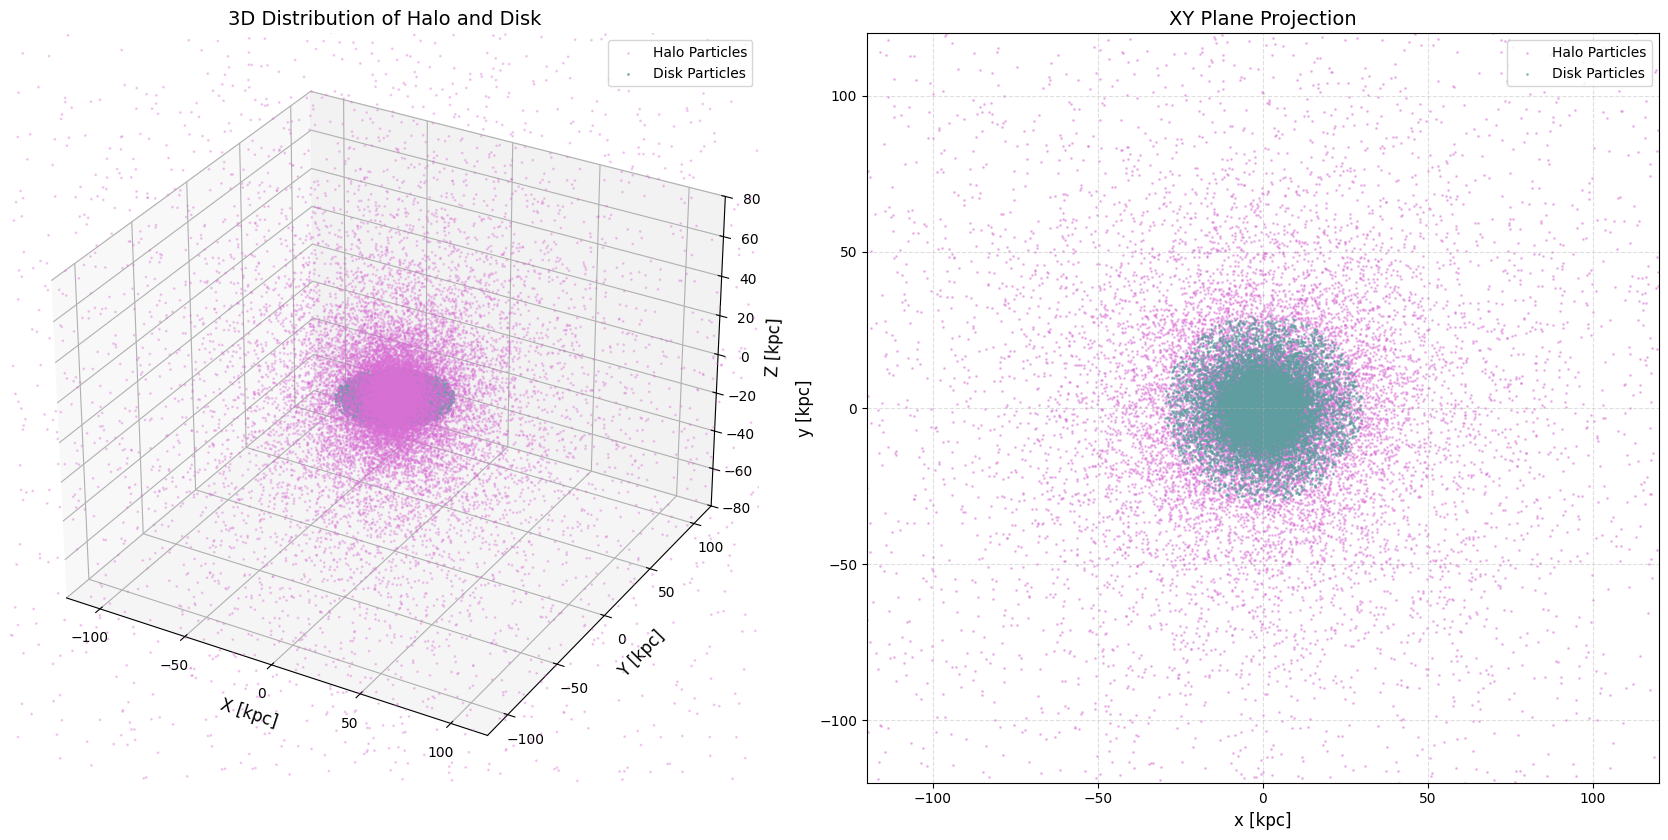

In [11]:
# Generate halo particle positions
N = num_particles

r_halo = a_H*(1 / (1 - np.sqrt(np.random.random(N))) - 1)
theta_halo = np.arccos(1 - 2*np.random.random(N))
phi_halo = np.random.uniform(0, 2*np.pi, N)

x_halo = r_halo*np.sin(theta_halo)*np.cos(phi_halo)
y_halo = r_halo*np.sin(theta_halo)*np.sin(phi_halo)
z_halo = r_halo*np.cos(theta_halo)

# Create a figure with two subplots
fig = plt.figure(figsize=(17, 8.5))

# 3D subplot: Left
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_halo, y_halo, z_halo, s=1, color='orchid', alpha=0.3, label='Halo Particles')
ax1.scatter(x_particles, y_particles, z_particles, s=1, color='cadetblue', alpha=0.75, label='Disk Particles')

ax1.set_title("3D Distribution of Halo and Disk", fontsize=14)
ax1.set_xlabel("X [kpc]", fontsize=12)
ax1.set_ylabel("Y [kpc]", fontsize=12)
ax1.set_zlabel("Z [kpc]", fontsize=12)
ax1.set_xlim(-120, 120)
ax1.set_ylim(-120, 120)
ax1.set_zlim(-80, 80)
ax1.legend(loc='upper right', fontsize=10)

# 2D projection: Right
ax2 = fig.add_subplot(122)
ax2.scatter(x_halo, y_halo, s=1, color='orchid', alpha=0.4, label='Halo Particles')
ax2.scatter(x_particles, y_particles, s=1, color='cadetblue', alpha=0.6, label='Disk Particles')

ax2.set_title("XY Plane Projection", fontsize=14)
ax2.set_xlabel("x [kpc]", fontsize=12)
ax2.set_ylabel("y [kpc]", fontsize=12)
ax2.set_xlim(-120, 120)
ax2.set_ylim(-120, 120)
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Gravitational Potentials and Velocities in Disk-Halo Systems

We model the gravitational potential of a galaxy by combining a stellar disk (Miyamoto–Nagai profile) and a dark matter halo (Hernquist profile).  
We are working in **internal units**, where $G = 1$, masses are expressed in **solar masses**, and distances in **kpc**.

---

### Halo Potential (Hernquist profile)

$$
\Phi_{\text{halo}}(R, z) = -\frac{G M_H}{\sqrt{R^2 + z^2} + a_H}
$$

---

### Disk Potential (Miyamoto–Nagai profile)

$$
\Phi_{\text{disk}}(R, z) = -\frac{G M_D}{\sqrt{(a + \sqrt{z^2 + b^2})^2 + R^2}}
$$

---

### Radial Derivative of the Potential (for circular velocity at $z = 0$)

$$
\frac{\partial \Phi}{\partial R} =\frac{\partial (\Phi_{\text{disk}}+\Phi_{\text{halo}})}{\partial R} = G R \left( M_D \left[\left(a_D + b\right)^2 + R^2\right]^{-\frac{3}{2}} + M_H \frac{1}{\left(R + A\right)^2 R} \right)
$$

---

### Circular Velocity

$$
v_{\text{circ}}(R) = \sqrt{R \, \frac{\partial \Phi}{\partial R}}
$$

---

### V_z Distribution

$$
f(v_z) = \frac{1}{\sqrt{2\pi} \sigma_z} \exp\left(-\frac{v_z^2}{2\sigma_z^2}\right)
$$

---

### Halo Density (Hernquist)

$$
\rho_{\text{halo}}(R, z) = \frac{M}{2\pi} \cdot \frac{a}{\sqrt{R^2 + z^2} \left(\sqrt{R^2 + z^2} + a\right)^3}
$$

---

### Disk Density (Miyamoto–Nagai)

$$
\rho_{\text{disk}}(R, z) = \frac{b^2 M_D}{4\pi} \cdot \frac{a R^2 + (a + 3 \sqrt{z^2 + b^2})(a + \sqrt{z^2 + b^2})^2}{\left[R^2 + (a + \sqrt{z^2 + b^2})^2\right]^{5/2} (z^2 + b^2)^{3/2}}
$$

---

### Notes on Enclosed Mass and Acceleration

#### Hernquist Enclosed Mass

In the Hernquist profile, the enclosed mass within radius $r$ is given by:

$$
M(<r) = M \cdot \frac{r^2}{(r + a)^2}
$$

However, **when computing acceleration from the gravitational potential**, the total mass $M$ is already accounted for in the expression:

$$
\Phi_{\text{halo}}(r) = -\frac{GM}{r + a}
$$

Therefore, **you do not need to recalculate the enclosed mass** $M(<r)$ separately when using this potential to derive forces. The potential already assumes that the **entire halo mass** contributes to the force at every radius.

*Reference: Binney & Tremaine, Galactic Dynamics – see §2.2 and §3.2.3*

---

#### Isothermal Vertical Distribution

In the vertical direction, assuming an isothermal sheet and equilibrium under self-gravity, the density profile follows:

$$
\rho(z) = \rho(0) \, \text{sech}^2 \left( \frac{z}{z_0} \right)
$$

where the **scale height** $z_0$ is related to the vertical velocity dispersion $\langle v_z^2 \rangle$ and the surface density $\sigma$ by:

$$
z_0 = \frac{\langle v_z^2 \rangle}{\pi G \sigma}
$$

The surface density $\sigma$ is related to the central density $\rho(0)$ as:

$$
\sigma = 2 \rho(0) z_0
$$

This structure is commonly used to model stellar disks in vertical equilibrium.

---

### **References**

- Binney & Tremaine, *Galactic Dynamics*, 2nd Ed.
- Hernquist (1990), ApJ, 356, 359
- Miyamoto & Nagai (1975), PASJ, 27, 533
- Mo, van den Bosch & White, *Galaxy Formation and Evolution*

In [12]:
G=1

In [13]:
def potential_halo(R, z):
    r = np.sqrt(R**2 + z**2)
    return -G*M_H/(r + a_H)

def potential_disk(R, z):
    return -G*M_D / np.sqrt((a + np.sqrt(z**2 + b**2))**2 + R**2)

def dphi_dr(R):  # At z = 0
    halo_term = G*M_H/(R + a_H)**2
    disk_term = G*M_D*R*((a + b)**2 + R**2)**(-1.5)
    return halo_term + disk_term

#Second derivative of the total potential (halo + disk) at z = 0
def second_dphi_dr(R):
    halo_term = -2*G*M_H/(R + a_H)**3
    disk_term = G*M_D*((a + b)**2 - 2*R**2)*((a + b)**2 + R**2)**(-2.5)
    return halo_term + disk_term

def circ_v(R):
    return np.sqrt(dphi_dr(R)*R)

def omega(R):
    return np.sqrt(dphi_dr(R)/R)

def kappa(R):
    return np.sqrt(second_dphi_dr(R) + 3*dphi_dr(R)/R)

#Hernquist halo density profile
def rho_H(R, z):
    return (M_H/(2*np.pi))*(a/(np.sqrt(R**2 + z**2) * (np.sqrt(R**2 + z**2) + a)**3))

def rho_tot(R, z):
    return rho_D(R, z) + rho_H(R, z)

#Radial velocity dispersion using Toomre's Q
def sigma_r(R, Q=1.1):
    S = Sigma(R)
    k = kappa(R)
    return 3.36*Q*G*S/k

#Compute surface density for a given array of R values
def Sigma(R_values):
    Sigma_values = np.zeros_like(R_values)
    for i, R in enumerate(R_values):
        Sigma_values[i] = 2*np.trapezoid(
            [rho_D(R, z) for z in np.linspace(0, z_max, 100)],
            dx=float(z_max / 100)
        )
    return Sigma_values

#Vertical velocity dispersion
def sigma_z(b, R_values):
    surface_density = Sigma(R_values)
    return np.sqrt(np.pi*G*surface_density*b/2)

def tot_potential(R, z):
    return potential_halo(R, z) + potential_disk(R, z)

def escape_vel(R, z):
    return np.sqrt(-2*tot_potential(R, z))

# **Positions and Surface Density**

This section visualizes the spatial distribution of disk particles in 3D, along with a wireframe representation of the gravitational potential surface generated by the Miyamoto–Nagai disk.  
The goal is to compare the mass density structure with the corresponding potential well.

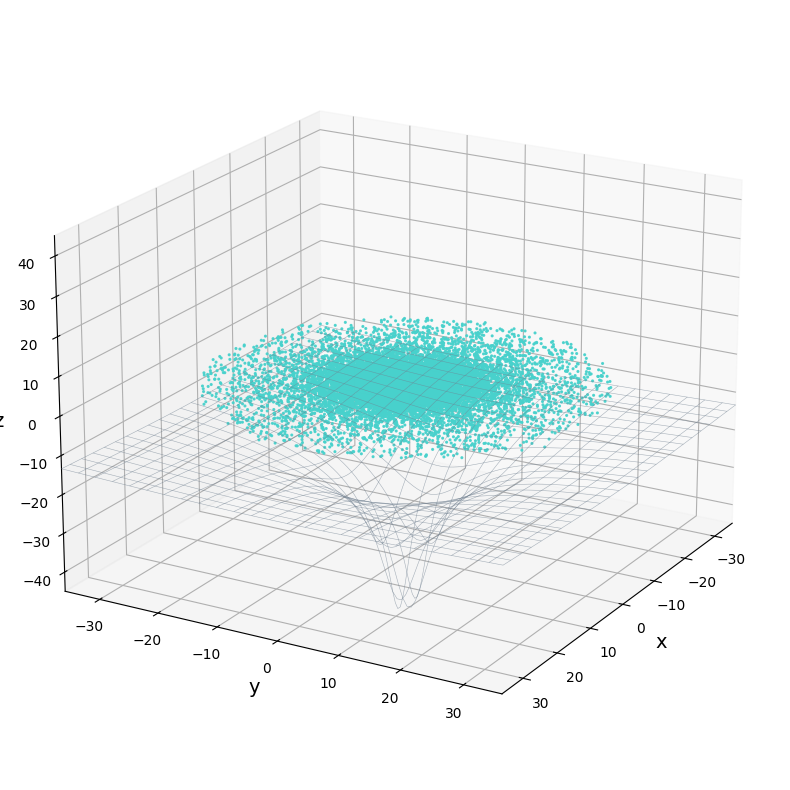

In [14]:
# Surface density and particle positions with 3D visualization

x_grid_pot = np.linspace(-12*a, 12*a, 100)
y_grid_pot = np.linspace(-12*a, 12*a, 100)
X, Y = np.meshgrid(x_grid_pot, y_grid_pot)

# Adjust Z surface for better contrast with particles
Z = -10 + 5*potential_disk(np.sqrt(X**2 + Y**2), np.zeros_like(X))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Wireframe for disk potential
ax.plot_wireframe(X, Y, Z, color='slategray', lw=0.4, alpha=0.6, rstride=4, cstride=4)
# Disk particles
ax.scatter(x_particles, y_particles, z_particles, s=1.5, c='mediumturquoise', alpha=0.9)
# Labels and limits
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14)
ax.set_zlabel('z', fontsize=14)
ax.set_xlim(-12 * a, 12 * a)
ax.set_ylim(-12 * a, 12 * a)
ax.set_zlim(-15 * a, 15 * a)

# Viewing angle
ax.view_init(elev=20, azim=30)
plt.tight_layout()
plt.show()

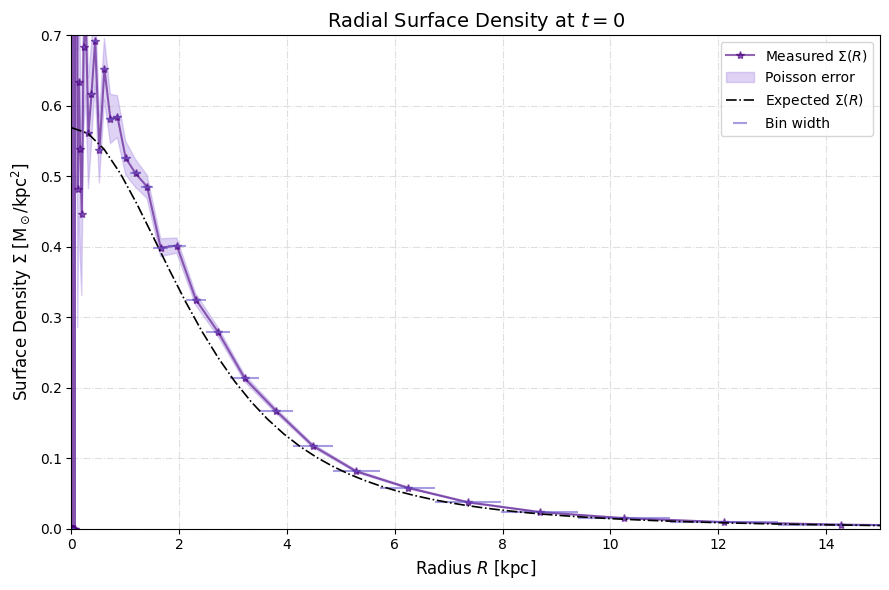

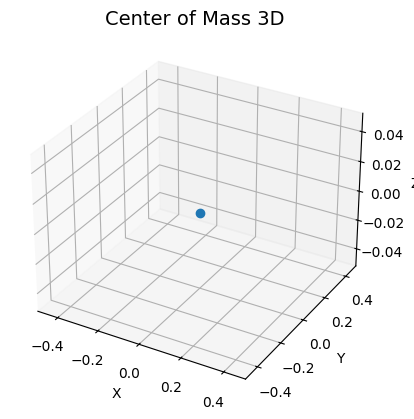

In [15]:
#Compute radial surface density profile using cylindrical annuli.
def surface_density_R(masses, positions, num_bins):
    x, y = positions[:, 0], positions[:, 1]
    R = np.sqrt(x**2 + y**2)

    bins = np.geomspace(R.min(), R.max(), num_bins)
    mass_per_bin, bin_edges = np.histogram(R, bins=bins, weights=masses)

    bin_areas = np.pi*(bin_edges[1:]**2 - bin_edges[:-1]**2)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

    sigma = mass_per_bin / bin_areas
    poisson_error = np.sqrt(mass_per_bin / masses[0])*masses[0] / bin_areas
    bin_width_error = 0.5*(bin_edges[1:] - bin_edges[:-1])

    return bin_centers, sigma, poisson_error, bin_width_error

# Prepare grid and particle info
R_grid = np.linspace(0, 30, 100)
particle_pos = np.array([x_particles, y_particles, z_particles]).T
masses = np.ones(num_particles) * m_particles

# Compute experimental surface density profile
bin_centers, sigma_exp, poisson_err, bin_widths = surface_density_R(masses, particle_pos, 50)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

# Experimental surface density from the simulation
ax.plot(bin_centers, sigma_exp, marker='*', color='indigo', alpha=0.6,
        label=r'Measured $\Sigma(R)$')

# Poisson error band
ax.fill_between(bin_centers,
                sigma_exp - poisson_err,
                sigma_exp + poisson_err,
                color='mediumpurple', alpha=0.3,
                label='Poisson error')

# Horizontal error bars showing bin widths
ax.errorbar(bin_centers, sigma_exp, xerr=bin_widths,
            fmt='none', ecolor='slateblue', alpha=0.6,
            label='Bin width')

# Theoretical surface density profile from the model
ax.plot(R_grid, Sigma(R_grid), '-.', color='black', linewidth=1.2,
        label=r'Expected $\Sigma(R)$')

# Aesthetics and labels
ax.set_title(r"Radial Surface Density at $t = 0$", fontsize=14)
ax.set_xlabel(r"Radius $R$ [kpc]", fontsize=12)
ax.set_ylabel(r"Surface Density $\Sigma$ [M$_\odot$/kpc$^2$]", fontsize=12)
ax.set_xlim(0, 15)
ax.set_ylim(0, 0.7)
ax.grid(True, linestyle='-.', alpha=0.4)
ax.legend()
plt.tight_layout()
plt.show()

def calc_center_of_mass_plot(m, x):
    m = m[:, np.newaxis]
    centers_mass = np.sum(m*x, axis=1) / np.sum(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    plt.plot(centers_mass[0], centers_mass[1], marker='o', linestyle='-')
    ax.set_title(r"Center of Mass 3D", fontsize=14)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.xlim(-0.5,0.5)
    plt.ylim(-0.5,0.5)
    plt.show()
    return centers_mass

cent_of_mass = calc_center_of_mass_plot(masses, particle_pos)

## Velocities

In this section, we compute several key velocity-related quantities for our disk-halo galaxy model

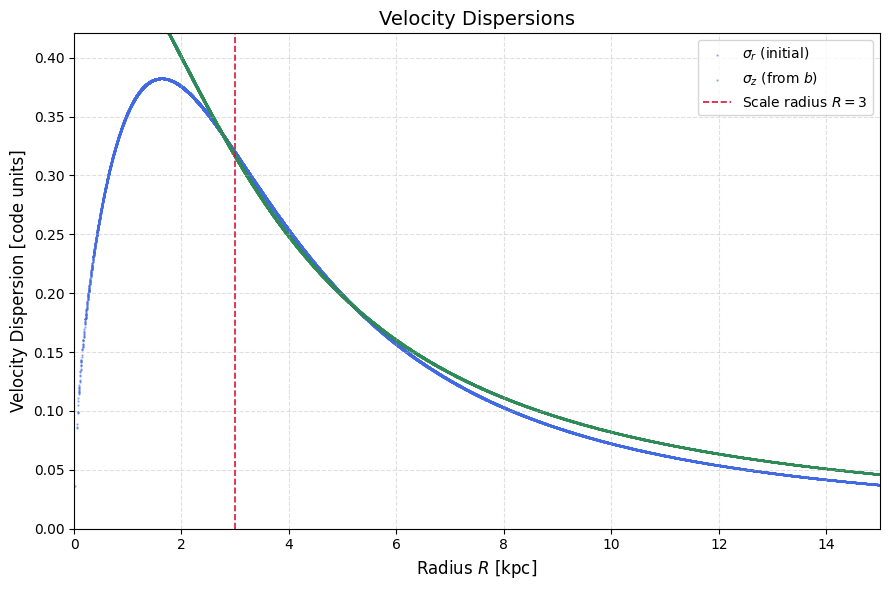

The guiding radius is: 6.72 kpc


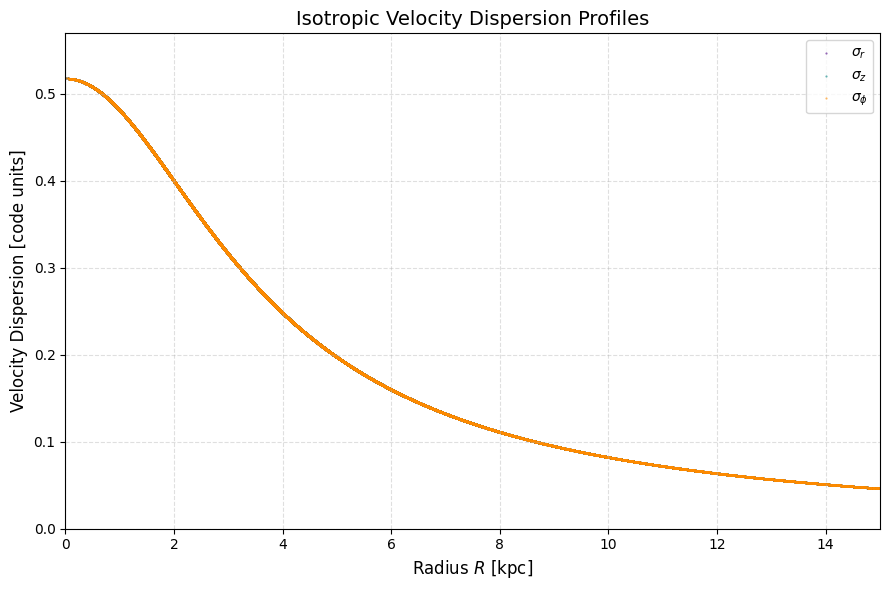

Circular velocities at particle positions:
[2.29487413 2.07083712 5.11268136 ... 5.25377504 4.1083566  1.05660327]


In [16]:
# Compute radial and vertical velocity dispersions
sigma_r_plot = sigma_r(R_particles)
sigma_z_plot = sigma_z(b, np.array(R_particles))

# Plot sigma_r and sigma_z
plt.figure(figsize=(9, 6))
plt.scatter(R_particles, sigma_r_plot, label=r'$\sigma_r$ (initial)', s=0.3, color='royalblue', alpha=0.6)
plt.scatter(R_particles, sigma_z_plot, label=r'$\sigma_z$ (from $b$)', s=0.3, color='seagreen', alpha=0.6)
plt.axvline(3, color='crimson', linestyle='--', linewidth=1.2, label='Scale radius $R = 3$')

plt.title("Velocity Dispersions", fontsize=14)
plt.xlabel("Radius $R$ [kpc]", fontsize=12)
plt.ylabel("Velocity Dispersion [code units]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(0, 15)
plt.ylim(0, np.max(sigma_r_plot)*1.1)
plt.legend()
plt.tight_layout()
plt.show()

# Compute the guiding radius as the average radius (disk only)
R_guid = np.mean(np.array(R_particles))  # We exclude the halo here

print(f'The guiding radius is: {R_guid:.2f} kpc')

# Assume equal dispersions in all components (isotropic approximation)
sig_r = sigma_z(b, np.array(R_particles))
sig_z = sig_r
sig_phi = sig_r

# Plot assumed sigma profiles
plt.figure(figsize=(9, 6))
plt.scatter(R_particles, sig_r, label=r'$\sigma_r$', s=0.3, color='indigo', alpha=0.6)
plt.scatter(R_particles, sig_z, label=r'$\sigma_z$', s=0.3, color='teal', alpha=0.6)
plt.scatter(R_particles, sig_phi, label=r'$\sigma_\phi$', s=0.3, color='darkorange', alpha=0.6)

plt.title("Isotropic Velocity Dispersion Profiles", fontsize=14)
plt.xlabel("Radius $R$ [kpc]", fontsize=12)
plt.ylabel("Velocity Dispersion [code units]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(0, 15)
plt.ylim(0, np.max(sig_r)*1.1)
plt.legend()
plt.tight_layout()
plt.show()

# Generate random velocity components from Gaussian distributions
v_r = sig_r * np.random.normal(size=num_particles)
v_phi = circ_v(np.array(R_particles)) + sig_phi * np.random.normal(size=num_particles)
v_x = -v_phi * np.sin(phi_particles) + v_r * np.cos(phi_particles)
v_y =  v_phi * np.cos(phi_particles) + v_r * np.sin(phi_particles)
v_z =  sig_z * np.random.normal(size=num_particles)

# Print circular velocity as a consistency check
print("Circular velocities at particle positions:")
print(circ_v(np.array(R_particles)))

### Virial Theorem Check

To verify whether our system is close to dynamical equilibrium, we evaluate the virial theorem:

\[
2T = |U|
\]

where:
- \( T \) is the total kinetic energy of the system,
- \( U \) is the total gravitational potential energy.

We compute the ratio \( $\frac{2T}{|U|} \$), which should be close to **1** in a virialized system. If the ratio deviates significantly from 1, the system is either not in equilibrium or still evolving.

Since we initialized velocities assuming a circular profile with small perturbations, we expect a result close to equilibrium, but not exact.

In [17]:
# Virial Theorem Check

# Kinetic energy
T = 0.5*np.sum(masses*(v_x**2 + v_y**2 + v_z**2))

# Potential energy using total potential
U = 0.5*np.sum(masses*tot_potential(R_particles, z_particles))

# Virial ratio
virial_ratio = 2*T/abs(U)

# Print results
print(f"Kinetic energy: {T:.2e}")
print(f"Potential energy: {U:.2e}")
print(f"Virial ratio (2T/|U|): {virial_ratio:.3f}")

Kinetic energy: 3.84e+02
Potential energy: -1.23e+03
Virial ratio (2T/|U|): 0.626


### Velocity Dispersion to Circular Velocity Ratio

We now analyze the ratio between the azimuthal velocity dispersion and the circular velocity (sigma/velocity), as a function of radius. This ratio provides insight into the level of random motion compared to ordered rotation within the disk. In equilibrium, this quantity is expected to be small in the inner regions and can increase with radius.


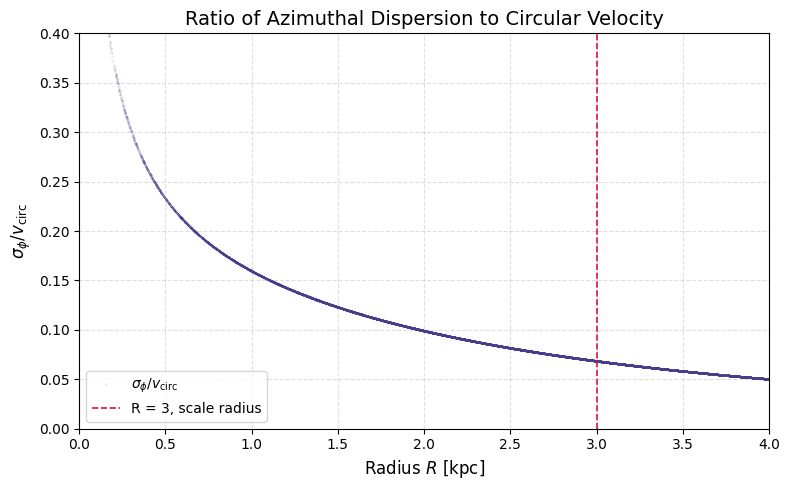

Value of ratio at R = 3: [0.06838276 0.06862895 0.06843555 0.06858391 0.06849671 0.06864245
 0.06853282 0.06867048 0.06881293 0.06883559 0.06844069 0.06869754
 0.06872067 0.06859763 0.06882604 0.06855165 0.06875682 0.06840271
 0.06839223 0.06855816 0.06877559 0.06867895 0.06843295 0.06860061
 0.06841815 0.06869443 0.06879022 0.06853741 0.06870433 0.06859171
 0.06842966 0.0684428  0.06868658 0.06857668 0.06873279 0.06869255
 0.06851789 0.06848552 0.06876381 0.06864042 0.06871934 0.06875408
 0.06873548 0.06845158 0.06871265 0.06842724 0.06841264 0.06844934
 0.0687788  0.06838004 0.06861407 0.06864732 0.06853922 0.06840891
 0.06859128 0.06870294 0.06878178 0.06839729 0.06880238 0.06852898
 0.06883903 0.06864151 0.06841094 0.06874737 0.06842018 0.06848802
 0.0688043  0.06880773 0.06864538 0.06856112 0.06883506 0.06871478
 0.06855373 0.06855399 0.06862063 0.06858662 0.06871153 0.06848587
 0.06881493 0.0684313  0.06863592 0.06883643 0.06839031]


In [16]:
ratio = sig_phi / circ_v(np.array(R_particles))
plt.figure(figsize=(8, 5))
plt.plot(R_particles, ratio, 'o', markersize = 0.2, color='darkslateblue', alpha=0.5, label=r'$\sigma_\phi / v_{\mathrm{circ}}$')

# Highlight R = 3 (scale radius)
plt.axvline(3, color = 'crimson', linestyle='--', linewidth=1.2, label = 'R = 3, scale radius')

# Axis limits and labels
plt.xlim(0,4)
plt.ylim(0,0.4)
plt.xlabel('Radius $R$ [kpc]', fontsize=12)
plt.ylabel(r'$\sigma_\phi / v_{\mathrm{circ}}$', fontsize=12)
plt.title('Ratio of Azimuthal Dispersion to Circular Velocity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

ratio_at_3 = ratio[np.isclose(R_particles, 3, atol=0.01)]
print(f'Value of ratio at R = 3: {ratio_at_3}')


## Toomre Stability Parameter

To assess the gravitational stability of the disk against axisymmetric perturbations, we compute the Toomre parameter Q at each radius. 

A value of 𝑄>1 indicates that the disk is locally stable against gravitational collapse. If 𝑄≲1, the disk becomes susceptible to instabilities, potentially forming bars or spiral arms.
We'll now evaluate Q(R) for our disk and visualize it as a function of radius.

Number of particles with Q < 1: 0
Q minumum 1.07739418625561


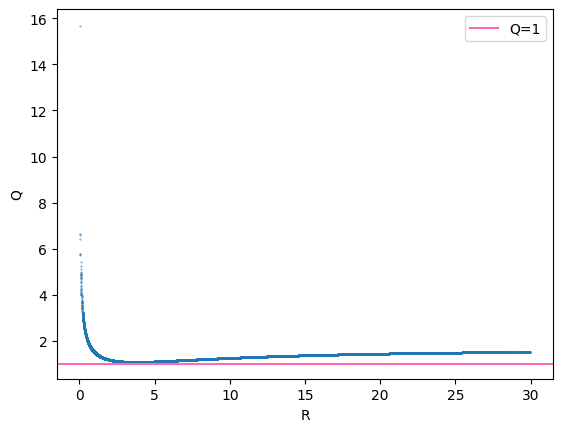

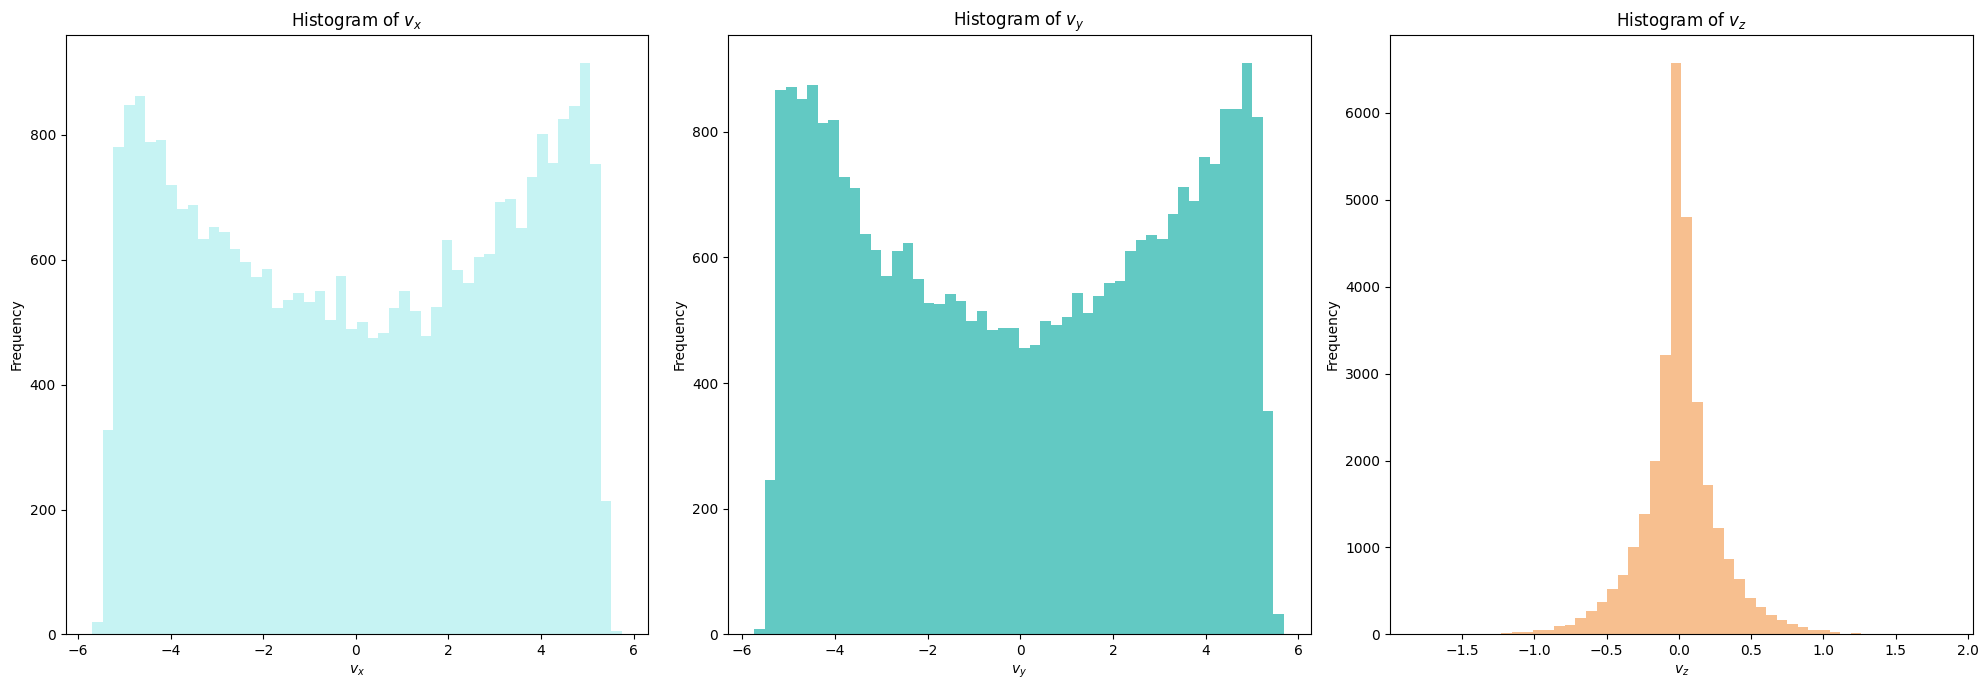

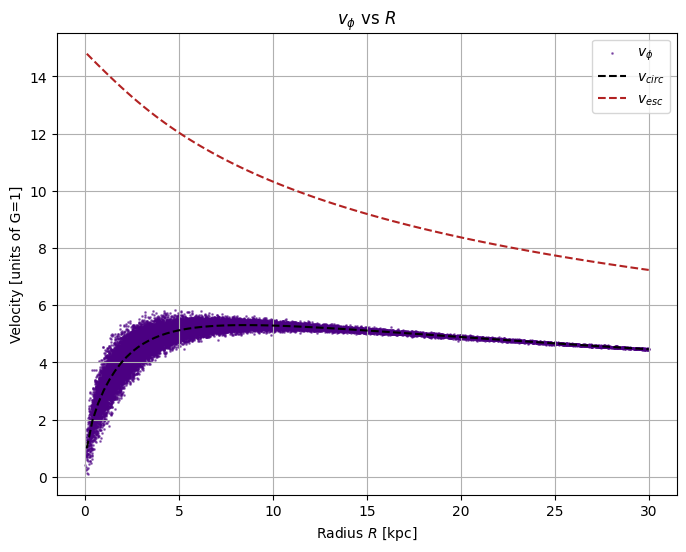

In [17]:
def Q(R, b):
    S = Sigma(R)
    k = kappa(R)
    sigma = sigma_z(b, R)
    return sigma*k/(3.36 *G*S)

b = b #a*0.03
Q_particles = Q(R_particles, b)

plt.scatter(R_particles, Q_particles, s = 0.1)
plt.axhline(1, color = 'hotpink', linestyle = '-', label = 'Q=1')
plt.xlabel('R') 
plt.ylabel('Q')
plt.legend()

num_particles_under_1 = np.sum(Q_particles < 1)
print(f'Number of particles with Q < 1: {num_particles_under_1}')

print("Q minumum", np.min(Q_particles))

# Histograms of the three velocity components
plt.figure(figsize=(20, 7))

# Histogram of v_x
plt.subplot(131)
plt.hist(v_x, bins=50, color='paleturquoise', alpha=0.7)
plt.title('Histogram of $v_x$')
plt.xlabel('$v_x$')
plt.ylabel('Frequency')

# Histogram of v_y
plt.subplot(132)
plt.hist(v_y, bins=50, color='lightseagreen', alpha=0.7)
plt.title('Histogram of $v_y$')
plt.xlabel('$v_y$')
plt.ylabel('Frequency')

# Histogram of v_z
plt.subplot(133)
plt.hist(v_z, bins=50, color='sandybrown', alpha=0.7)
plt.title('Histogram of $v_z$')
plt.xlabel('$v_z$')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

R_grid = np.linspace(0.1, R_max, 100)
# Scatter plot of v_phi as a function of R with circular velocity overplotted
plt.figure(figsize=(8, 6))
plt.scatter(R_particles, v_phi, s=1, color='indigo', alpha=0.5, label='$v_\\phi$')
plt.plot(R_grid, circ_v(R_grid), color='black', linestyle='--', label='$v_{circ}$')
plt.plot(R_grid, escape_vel(R_grid, 0), color='firebrick', linestyle='--', label='$v_{esc}$')
plt.xlabel('Radius $R$ [kpc]')
plt.ylabel('Velocity [units of G=1]')
plt.title('$v_\\phi$ vs $R$ ')
plt.legend()
plt.grid(True)
plt.show()

## Bar Formation Study

Having analyzed the radial stability of the disk through the **Toomre Q parameter**, we observed that $Q \gtrsim 1$, suggesting that the disk is marginally stable but still susceptible to the formation of non-axisymmetric structures—like a **bar**.

A galactic bar is often triggered when specific **orbital resonances** occur. In particular, the **Inner Lindblad Resonance (ILR)** can play a crucial role. A resonance appears when the orbital angular frequency $\Omega(R)$ and the **epicyclic frequency** $\kappa(R)$ satisfy the condition:

$$
f(R) = \Omega_{tot} (R) - \frac{1}{2} k_{tot} (R)
$$

If this function $f(R)$ intersects a possible **pattern speed** $\Omega_p$, it marks a potential location for the ILR—where stars are trapped into elliptical orbits aligned with the bar.

In this section, we'll explore the conditions required for **bar formation**, investigate the orbital structure of the disk, and look for key resonances that may trigger a bar instability. By analyzing the profiles of $\Omega(R)$ and $\kappa(R)$, we aim to identify whether our system is dynamically prone to the emergence of a bar.

Particles in interval: 20132
Zero crossings range from R = 1.71 to R = 6.80 (total = 60)


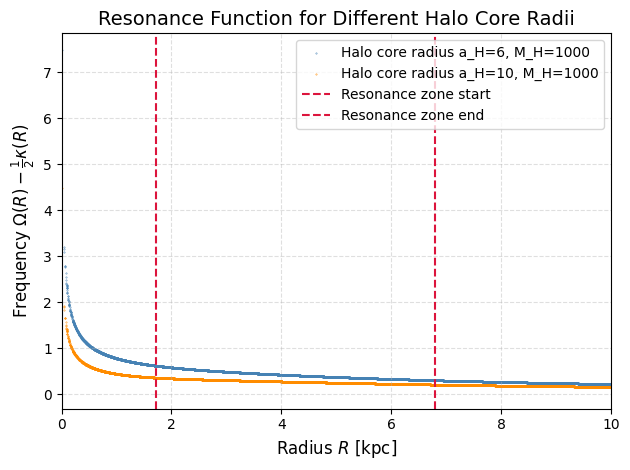

In [18]:
def freq(R):
    """Resonance function: Omega(R) - 0.5 * kappa(R)"""
    return omega(R) - 0.5*kappa(R)

# Select a valid radial range
R_part_interval = R_particles[(R_particles > 0) & (R_particles < 7)]
print(f"Particles in interval: {len(R_part_interval)}")

# First configuration
a_H = 6
M_H = 1000
plt.scatter(R_particles, freq(R_particles), s=0.1, color='steelblue', label=f'Halo core radius a_H={a_H}, M_H={M_H}')

# Second configuration
a_H = 10
M_H = 1000
plt.scatter(R_particles, freq(R_particles), s=0.1, color='darkorange', label=f'Halo core radius a_H={a_H}, M_H={M_H}')

# Find zero crossings in the frequency gradient
gradient_freq = np.gradient(freq(R_part_interval), R_part_interval)
zero_crossings = np.where(np.isclose(gradient_freq, 0, atol=1e-3))[0]
min_interval = np.min(R_part_interval[zero_crossings])
max_interval = np.max(R_part_interval[zero_crossings])

print(f"Zero crossings range from R = {min_interval:.2f} to R = {max_interval:.2f} (total = {len(zero_crossings)})")

# Highlight resonance interval
plt.axvline(min_interval, color='crimson', linestyle='--', label='Resonance zone start')
plt.axvline(max_interval, color='crimson', linestyle='--', label='Resonance zone end')

# Plot styling
plt.xlabel('Radius $R$ [kpc]', fontsize=12)
plt.ylabel(r'Frequency $\Omega(R) - \frac{1}{2}\kappa(R)$', fontsize=12)
plt.title('Resonance Function for Different Halo Core Radii', fontsize=14)
plt.xlim(0, 10)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

We plot $f(R)$ for two different halo configurations:

Blue: halo core radius $a_H = 6$, mass $M_H = 1000$

Orange: halo core radius $a_H = 10$, mass $M_H = 1000$

The red dashed lines indicate a radial interval where the gradient of $f(R)$ is close to zero. This suggests a potential resonance region, where orbital and epicyclic frequencies align in a way that favors the formation of a bar.

This type of analysis helps us determine where bars are more likely to develop and whether the system is dynamically favorable for such instabilities. In future steps, this will be compared with the pattern speed $\Omega_p$ of the rotating structure.

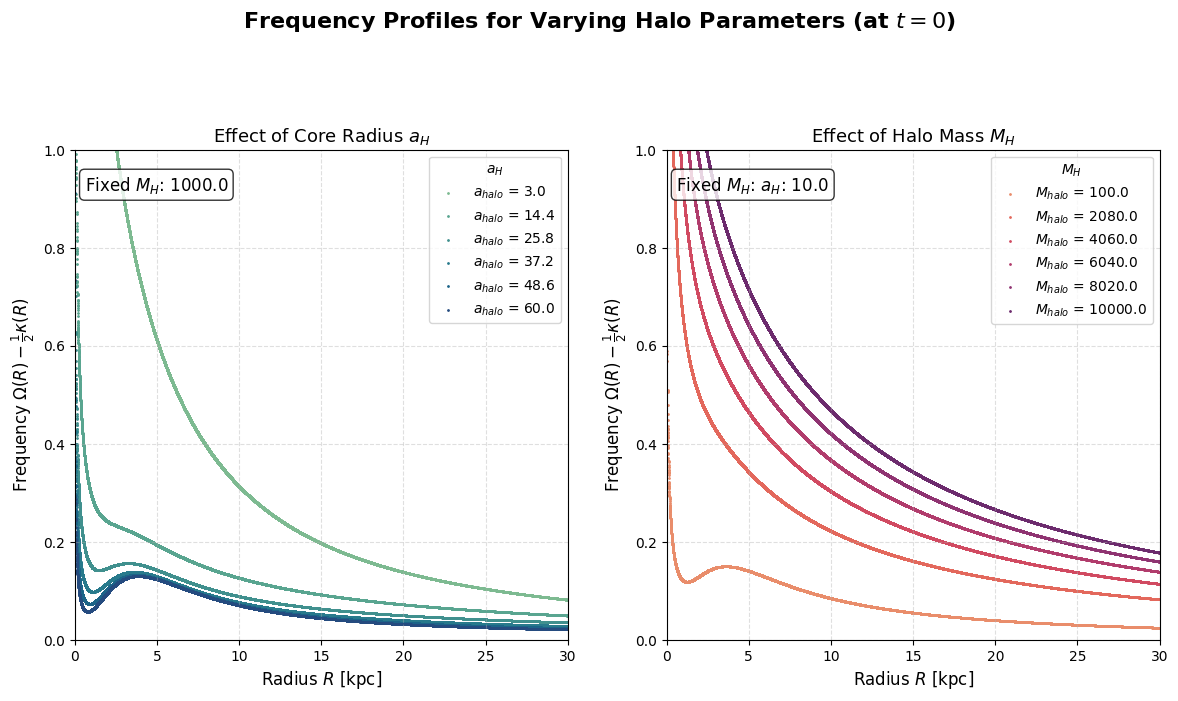

In [19]:
if len(zero_crossings) < 500:
    def freq(R):
        return omega(R) - 0.5 * kappa(R)
        
    # Generate parameter ranges
    a_halo_i = np.linspace(1, 20, 6) * a
    M_halo_i = np.linspace(0.1, 10, 6) * M_H

    # Create pastel color palettes
    colors_a_halo = sns.color_palette("crest", len(a_halo_i))  # soft greens/blues
    colors_M_halo = sns.color_palette("flare", len(M_halo_i))  # soft reds/purples

    fig = plt.figure(figsize=(14, 14))
    fig.suptitle('Frequency Profiles for Varying Halo Parameters (at $t=0$)', fontsize=16, weight='bold')

    # Plot for varying a_H
    ax1 = fig.add_subplot(221)
    for idx, a_H in enumerate(a_halo_i):
        ax1.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')
        
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 30)
    ax1.set_xlabel('Radius $R$ [kpc]', fontsize=12)
    ax1.set_ylabel('Frequency $\\Omega(R) - \\frac{1}{2}\\kappa(R)$', fontsize=12)
    ax1.set_title('Effect of Core Radius $a_H$', fontsize=13)
    ax1.grid(True, linestyle='--', alpha=0.4)
    ax1.legend(loc='upper right', fontsize=10, title='$a_H$', frameon=True)

    # Box with fixed parameter
    ax1.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}',
        transform=ax1.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    a_H = 10

    # Plot for varying M_H
    ax2 = fig.add_subplot(222)
    for idx, M_H in enumerate(M_halo_i):
        ax2.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')
        
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 30)
    ax2.set_xlabel('Radius $R$ [kpc]', fontsize=12)
    ax2.set_ylabel('Frequency $\\Omega(R) - \\frac{1}{2}\\kappa(R)$', fontsize=12)
    ax2.set_title('Effect of Halo Mass $M_H$', fontsize=13)
    ax2.grid(True, linestyle='--', alpha=0.4)
    ax2.legend(loc='upper right', fontsize=10, title='$M_H$', frameon=True)
    

    # Box with fixed parameter
    ax2.text(
        0.02, 0.95, f'Fixed $M_H$: $a_H$: {a_H:.1f}',
        transform=ax2.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    # Reset to original values
    M_H = 1000
    a_H = 10
else:
    print("The zero_crossings vector is not shorter than 500.")

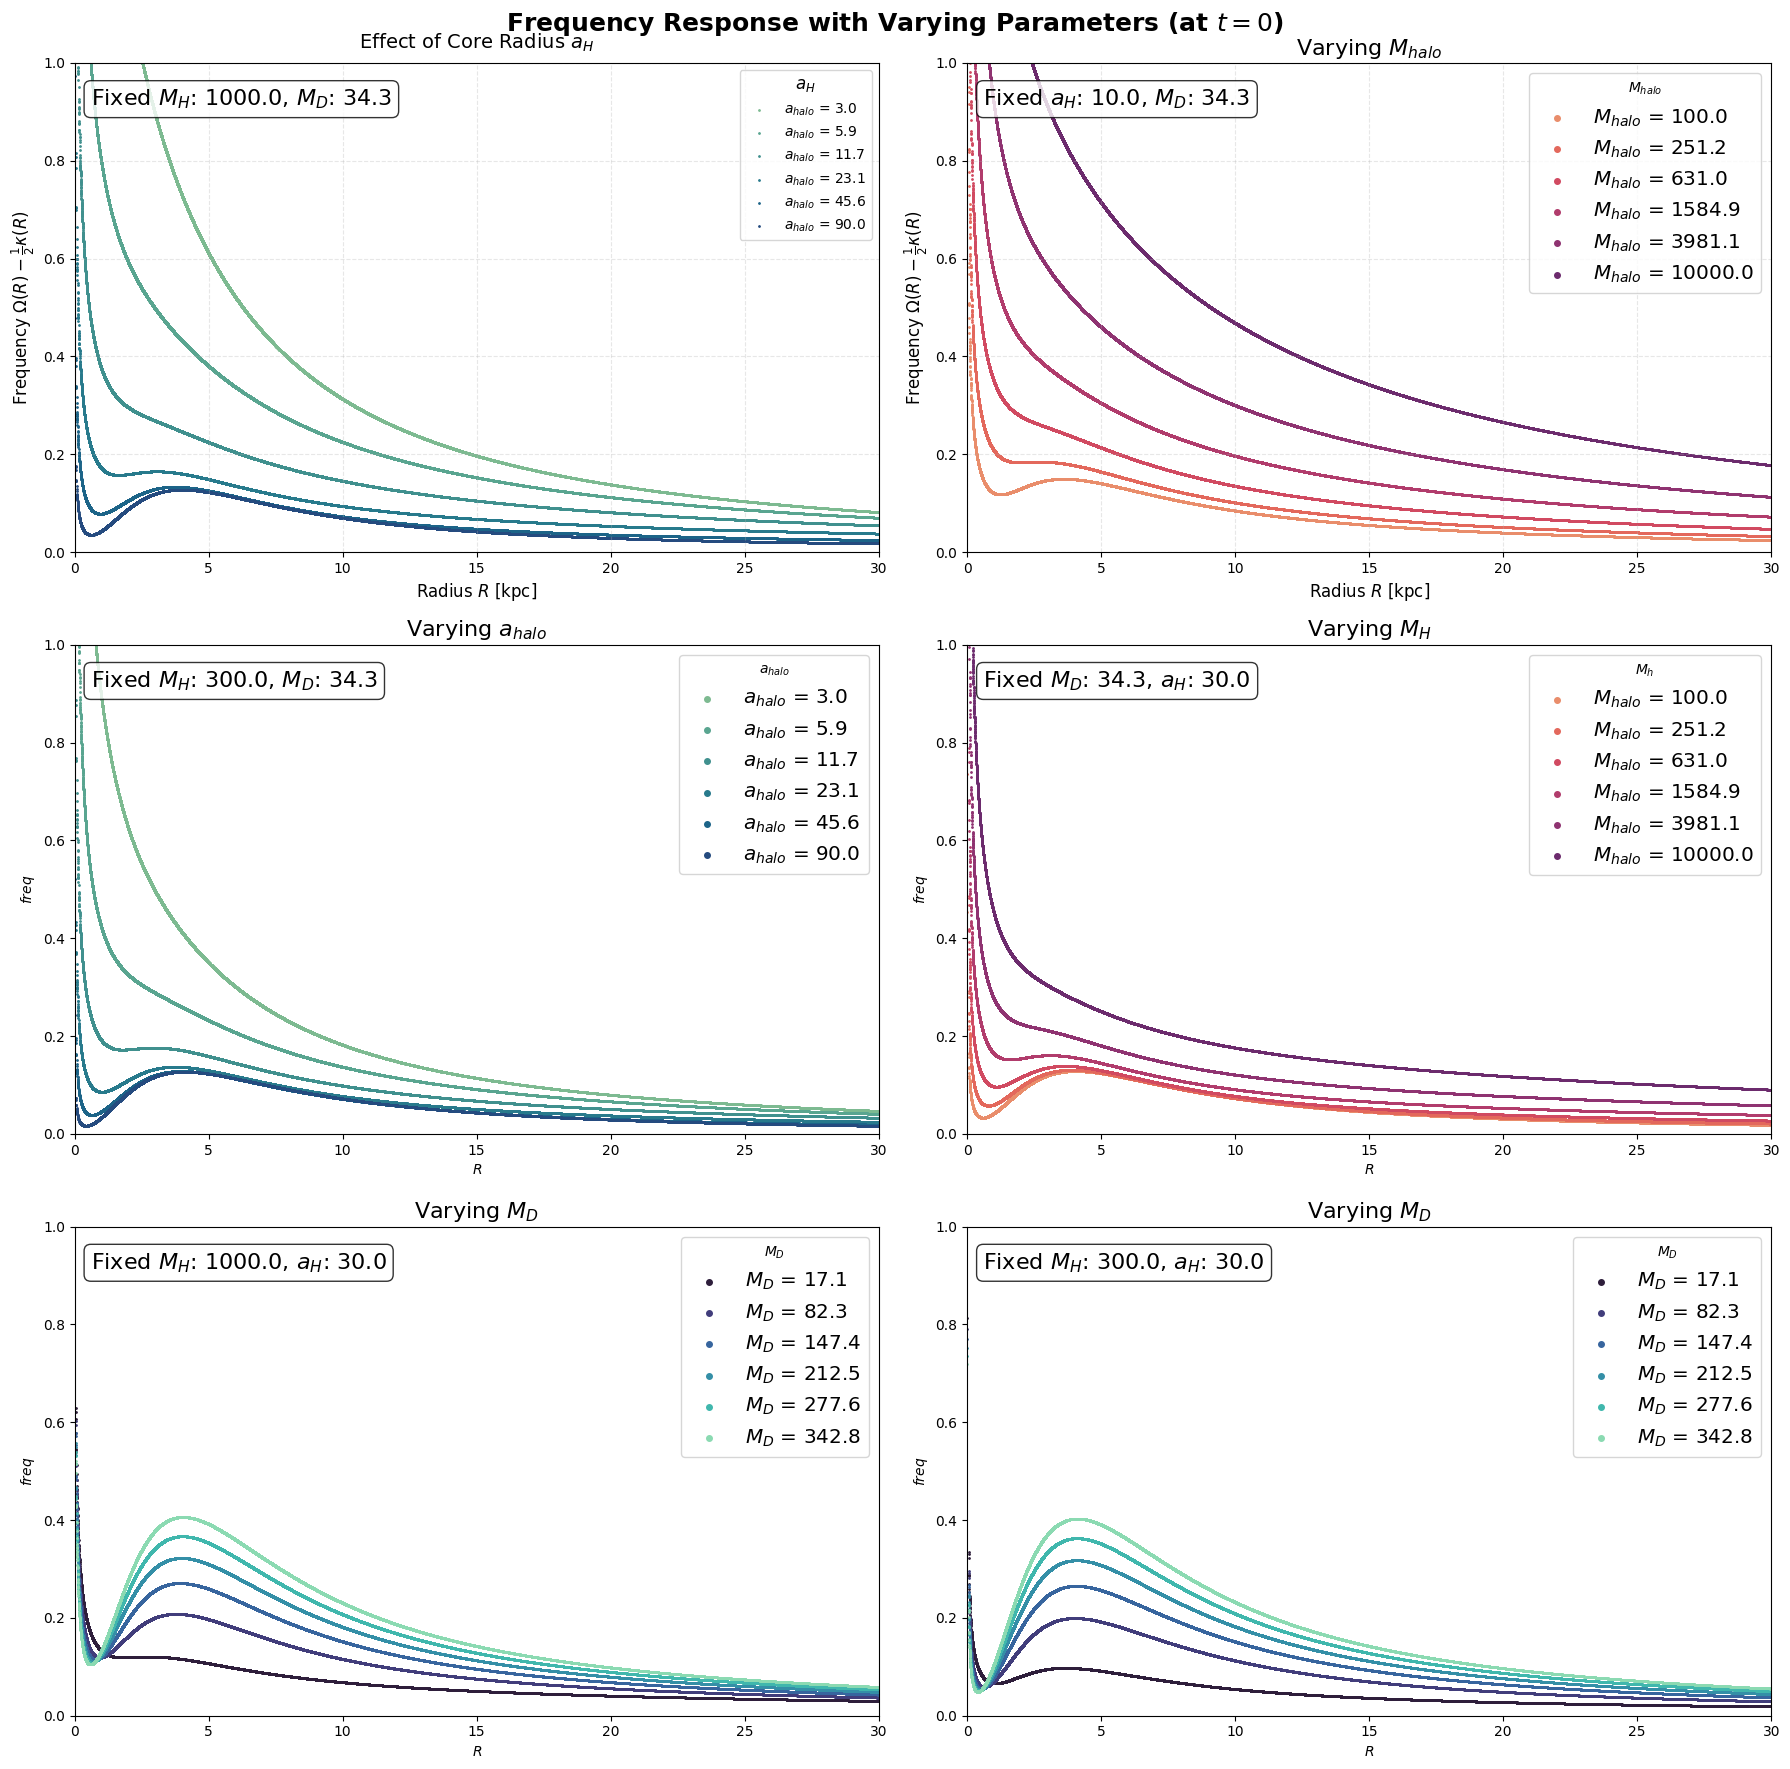

In [20]:
if len(zero_crossings) < 500:
    
    a_halo_i = np.geomspace(1, 30, 6) * a
    M_halo_i = np.geomspace(0.1, 10, 6) * M_H
    M_D_i = np.linspace(0.5, 10, 6) * M_D  # Define M_D range

    # Valori fissati
    fixed_params = f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}, $M_D$: {M_D:.1f}'

    # Crea palette di colori pastello
    colors_a_halo = sns.color_palette("crest", len(a_halo_i))
    colors_M_halo = sns.color_palette("flare", len(M_halo_i))
    colors_M_D = sns.color_palette("mako", len(M_D_i))  # Palette for M_D

    fig = plt.figure(figsize=(18, 18))
    fig.suptitle('Frequency Response with Varying Parameters (at $t=0$)', fontsize=18, fontweight='bold')

    # Plot for varying a_H
    ax1 = fig.add_subplot(321)
    for idx, a_H in enumerate(a_halo_i):
        ax1.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')

    # Aesthetics
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 30)
    ax1.set_xlabel(r"Radius $R$ [kpc]", fontsize=12)
    ax1.set_ylabel(r"Frequency $\Omega(R) - \frac{1}{2}\kappa(R)$", fontsize=12)
    ax1.set_title("Effect of Core Radius $a_H$", fontsize=14, pad=10)
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Legend
    ax1.legend(
    loc='upper right',
    fontsize='medium',
    title=r"$a_H$",
    title_fontsize='large',
    frameon=True,
    facecolor='white'
    )

    # Add fixed parameters box
    ax1.text(
        0.02, 0.95,  f'Fixed $M_H$: {M_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax1.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    a_H = 10

    # Plot for varying M_H
    ax2 = fig.add_subplot(322)
    for idx, M_H in enumerate(M_halo_i):
        ax2.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')

    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 30)
    ax2.set_xlabel(r"Radius $R$ [kpc]", fontsize=12)
    ax2.set_ylabel(r"Frequency $\Omega(R) - \frac{1}{2}\kappa(R)$", fontsize=12)
    ax2.legend(loc='upper right', fontsize='x-large', title='$M_{halo}$', scatterpoints=1, markerscale=4)
    ax2.set_title('Varying $M_{halo}$',fontsize = 16 )
    ax2.grid(True, linestyle='--', alpha=0.3)

    # Add fixed parameters box
    ax2.text(
        0.02, 0.95, f'Fixed $a_H$: {a_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax2.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    M_H = 1000  
    a_H = 30

    # Plot for varying M_H with higher a_H
    ax4 = fig.add_subplot(324)
    for idx, M_H in enumerate(M_halo_i):
        ax4.scatter(R_particles, freq(R_particles), s=1, color=colors_M_halo[idx], label=f'$M_{{halo}}$ = {M_H:.1f}')


    ax4.set_ylim(0, 1)
    ax4.set_xlim(0, 30)
    ax4.set_xlabel('$R$')
    ax4.set_ylabel('$freq$')
    ax4.legend(loc='upper right', fontsize='x-large', title='$M_h$', scatterpoints=1, markerscale=4)
    ax4.set_title( 'Varying $M_{H}$',fontsize = 16)

    # Add fixed parameters box
    ax4.text(
        0.02, 0.95, f'Fixed $M_D$: {M_D:.1f}, $a_H$: {a_H:.1f}',
        transform=ax4.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    M_H = 1000
    a_H = 30

    # Plot for varying M_D
    ax5 = fig.add_subplot(325)
    for idx, M_D in enumerate(M_D_i):
        ax5.scatter(R_particles, freq(R_particles), s=1, color=colors_M_D[idx], label=f'$M_{{D}}$ = {M_D:.1f}')

    ax5.set_ylim(0, 1)
    ax5.set_xlim(0, 30)
    ax5.set_xlabel('$R$')
    ax5.set_ylabel('$freq$')
    ax5.legend(loc='upper right', fontsize='x-large', title='$M_D$', scatterpoints=1, markerscale=4)
    ax5.set_title('Varying $M_{D}$',fontsize = 16)

    # Add fixed parameters box
    ax5.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}',
        transform=ax5.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


    M_D = M_D_1
    M_H = 300

     # Plot for varying a_H
    ax3 = fig.add_subplot(323)
    for idx, a_H in enumerate(a_halo_i):
        ax3.scatter(R_particles, freq(R_particles), s=1, color=colors_a_halo[idx], label=f'$a_{{halo}}$ = {a_H:.1f}')

    ax3.set_ylim(0, 1)
    ax3.set_xlim(0, 30)
    ax3.set_xlabel('$R$')
    ax3.set_ylabel('$freq$')
    ax3.legend(loc='upper right', fontsize='x-large', title='$a_{halo}$', scatterpoints=1, markerscale=4)
    ax3.set_title('Varying $a_{halo}$', fontsize = 16)

    # Add fixed parameters box
    ax3.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $M_D$: {M_D:.1f}',
        transform=ax3.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )


    a_H = 30
    M_H = 300


    # Plot for varying M_D
    ax6 = fig.add_subplot(326)
    for idx, M_D in enumerate(M_D_i):
        ax6.scatter(R_particles, freq(R_particles), s=1, color=colors_M_D[idx], label=f'$M_{{D}}$ = {M_D:.1f}')
    
    ax6.set_ylim(0, 1)
    ax6.set_xlim(0, 30)
    ax6.set_xlabel('$R$')
    ax6.set_ylabel('$freq$')
    ax6.legend(loc='upper right', fontsize='x-large', title='$M_D$', scatterpoints=1, markerscale=4)
    ax6.set_title('Varying $M_{D}$',fontsize = 16)

    # Add fixed parameters box
    ax6.text(
        0.02, 0.95, f'Fixed $M_H$: {M_H:.1f}, $a_H$: {a_H:.1f}',
        transform=ax6.transAxes, fontsize=16, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    plt.show()

    # Reset to original values
    M_H = 1000
    a_H = 10
    M_D = M_D_1
else:
    print("The zero_crossings vector is not shorter than 500.")

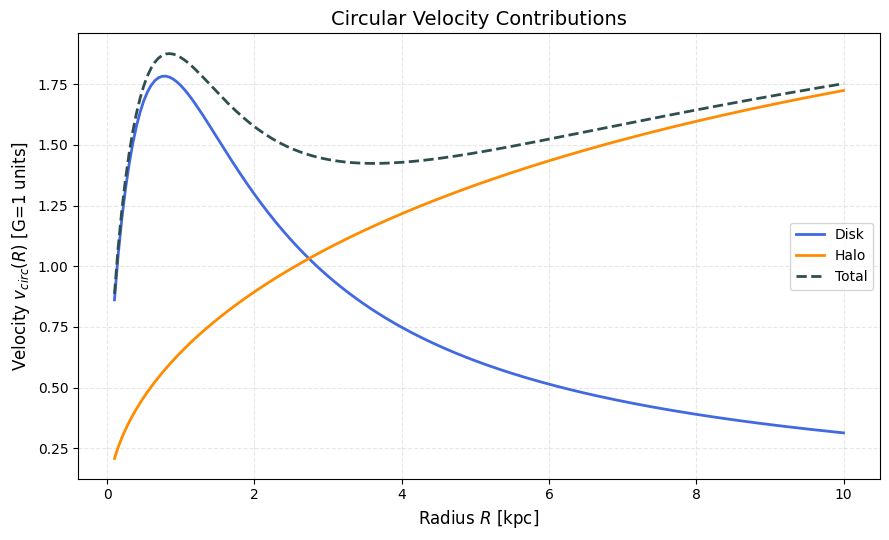

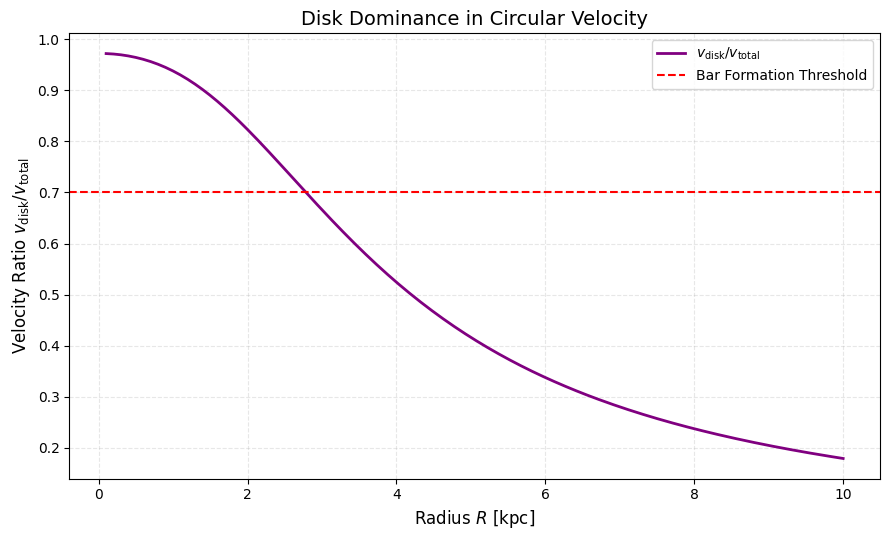

In [21]:
# --- Functions for circular velocity contributions ---

def v_circ_disk(R, G=1, M_D=10, a=1, b=0.1):
    """Returns the circular velocity due to the disk component."""
    return np.sqrt(G * M_D * R / ((a + np.sqrt(b**2))**2 + R**2)**(3/2))

def v_circ_halo(R, G=1, M_H=1000, a_h=48):
    """Returns the circular velocity due to the halo component (Hernquist profile)."""
    return np.sqrt(G * M_H * R / (R + a_h)**2)

# --- Radial range and velocity computations ---
R_values = np.linspace(0.1, 10, 200)  # Avoid division by zero at R=0

v_disk = v_circ_disk(R_values)
v_halo = v_circ_halo(R_values)
v_total = np.sqrt(v_disk**2 + v_halo**2)

# --- Plot: Velocity contributions ---
plt.figure(figsize=(9, 5.5))
plt.plot(R_values, v_disk, label="Disk", color='royalblue', linewidth=2)
plt.plot(R_values, v_halo, label="Halo", color='darkorange', linewidth=2)
plt.plot(R_values, v_total, '--', label="Total", color='darkslategray', linewidth=2)

plt.title("Circular Velocity Contributions", fontsize=14)
plt.xlabel("Radius $R$ [kpc]", fontsize=12)
plt.ylabel("Velocity $v_{circ}(R)$ [G=1 units]", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# --- Plot: Disk-to-total velocity ratio ---
v_ratio = v_disk / v_total

plt.figure(figsize=(9, 5.5))
plt.plot(R_values, v_ratio, color="purple", linewidth=2, label=r"$v_{\mathrm{disk}} / v_{\mathrm{total}}$")
plt.axhline(0.7, linestyle="--", color="red", label="Bar Formation Threshold")

plt.title("Disk Dominance in Circular Velocity", fontsize=14)
plt.xlabel("Radius $R$ [kpc]", fontsize=12)
plt.ylabel(r"Velocity Ratio $v_{\mathrm{disk}} / v_{\mathrm{total}}$", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### Treecode Initialization: Softening and Acceleration

To prepare for the simulation, we compute the gravitational softening length based on the system's mass distribution and estimate the maximum particle acceleration.

This value will be used to determine the optimal timestep for the integrator and ensure numerical stability. The acceleration is calculated from the combined potential of:
- A Hernquist dark matter halo
- A Miyamoto-Nagai stellar disk

In [22]:
# --- Treecode Parameters ---

# Estimate the volume from max density
volume = (M_D + 1.1425)/np.max(rho_D(np.array(R_particles), np.array(z_particles)))

# Compute softening length assuming particles are uniformly distributed in volume
softening = (volume / num_particles)**(1/3)
print(f'Softening parameter = {softening:.3f}')


# --- Accelerations without external perturbers ---
def calculate_accelerations(R, z):
    """Compute radial and vertical accelerations from the halo + disk potential."""
    
    # Spherical distance (softening could be included here if needed)
    r = np.sqrt(R**2 + z**2)

    # Hernquist halo acceleration
    denominator_halo = (r + a_H)**2
    acc_R_halo = -G*M_H*R/(r*denominator_halo)
    acc_z_halo = -G*M_H*z/(r*denominator_halo)

    # Miyamoto-Nagai disk acceleration
    sqrt_zb2 = np.sqrt(z**2 + b**2)
    denominator_disk = ((a + sqrt_zb2)**2 + R**2)**1.5
    acc_R_disk = -G*M_D*R/denominator_disk
    acc_z_disk = -G*M_D*z*(a + sqrt_zb2)/(sqrt_zb2*denominator_disk)

    # Total acceleration (vector sum)
    acc_R_total = acc_R_halo + acc_R_disk
    acc_z_total = acc_z_halo + acc_z_disk
    
    return acc_R_total, acc_z_total

# Compute accelerations for all particles
acc_R, acc_z = calculate_accelerations(np.array(R_particles), np.array(z_particles))
acc_total = np.sqrt(acc_R**2 + acc_z**2)

# Maximum acceleration: used for setting stable timestep
acc_max = np.max(acc_total)
print(f"Maximum acceleration: {acc_max:.5e}")

Softening parameter = 0.106
Maximum acceleration: 1.15033e+01


In [23]:
# Estimate timestep based on maximum acceleration and softening
dt = 0.5*np.sqrt(softening / acc_max)
print('Timestep:', dt)

# Estimate orbital period
T = 2*np.pi*R_particles/circ_v(R_particles)
print('Orbital periods: ', T)
print('Suggested timestep (1/100 of min period):', np.min(T)/100)

# Estimate dynamical timescale from average density
density_mean = np.mean(rho_D(np.array(R_particles), np.array(z_particles)))
t_dyn = np.sqrt(1 / density_mean)
print(f'Dynamical timescale = {t_dyn:.2f}')

# Write initial conditions to file in Treecode format
def w_onfile(filename, num_points, mass, dimension, x, y, z, v_x, v_y, v_z):
    with open(filename, 'w') as file:
        file.write(f'  {num_points} \n  {dimension} \n  {0}  \n')
        for i in range(num_points):
            file.write(f'  {mass}  \n')
        for i in range(num_points):
            file.write(f'  {x[i]}  {y[i]}  {z[i]}  \n')
        for i in range(num_points):
            file.write(f'  {v_x[i]}  {v_y[i]}  {v_z[i]} \n')

# Save the data to a txt file
filename = 'treecode_in_EQUILIBRIUM.txt'
w_onfile(filename, num_particles, M_D/num_particles, 3, x_particles, y_particles, z_particles, v_x, v_y, v_z)


Timestep: 0.048048156049392055
Orbital periods:  [1.52046356 1.35865356 6.08621637 ... 7.74961752 3.21419668 0.67157815]
Suggested timestep (1/100 of min period): 0.0018802600836164134
Dynamical timescale = 2.48


In [24]:
!./treecode in=treecode_in_EQUILIBRIUM_1.txt out=treecode_out_EQUILIBRIUM_1.txt dtime=0.005 eps=0.106 theta=0.3 tstop=100 dtout=1.5 > output_EQUILIBRIUM_1.txt
